In [1]:
# show all warnings

import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
# import various packages

import sys as _sys
import pickle as _pkl
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import scipy.stats as _sts
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
# import eQTLseq
_sys.path.append('../')
import eQTLseq as _assoc

In [51]:
# load simulated data, or ...

with open('../data/simdata_correlated.pkl', 'rb') as fh:
    data = _pkl.load(fh)

(2504, 435) (1000, 2504)


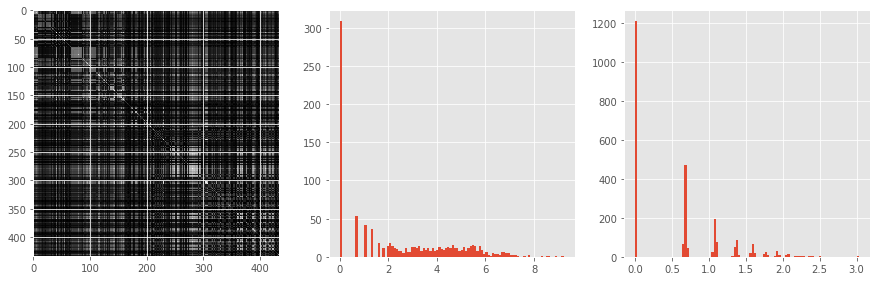

In [52]:
# prepare data

Z = data['Z']
G = data['G']

Z = Z[Z.sum(1) > 0, :]       # keep only expressed tags
# Z = Z[Z.sum(1) > _nmp.percentile(Z.sum(1), 60), :]
G = G[:, _nmp.std(G, 0) > 0] # keep only non-monomorphic loci

Z = Z / _assoc.calculate_norm_factors(Z)
Z = _assoc.transform_data(Z, kind='log')

print(G.shape, Z.shape)

# take a quick look at the data

_plt.figure(figsize=(15,10));
_plt.subplot(2,3,1); _plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);
_plt.subplot(2,3,2); _plt.hist(Z[:, 0], bins=100);
_plt.subplot(2,3,3); _plt.hist(Z[0, :], bins=100);

In [53]:
# estimate model
# _rnd.seed(0)
res = _assoc.run(Z.T, G, n_iters = 2000, model='Normal', scaleG=True, n_threads=1)

100%|██████████| 2000/2000 [04:28<00:00,  7.46it/s]


(1.0443198009572727, 1322573137457484.0, 0.49999770113885583, 0.5)

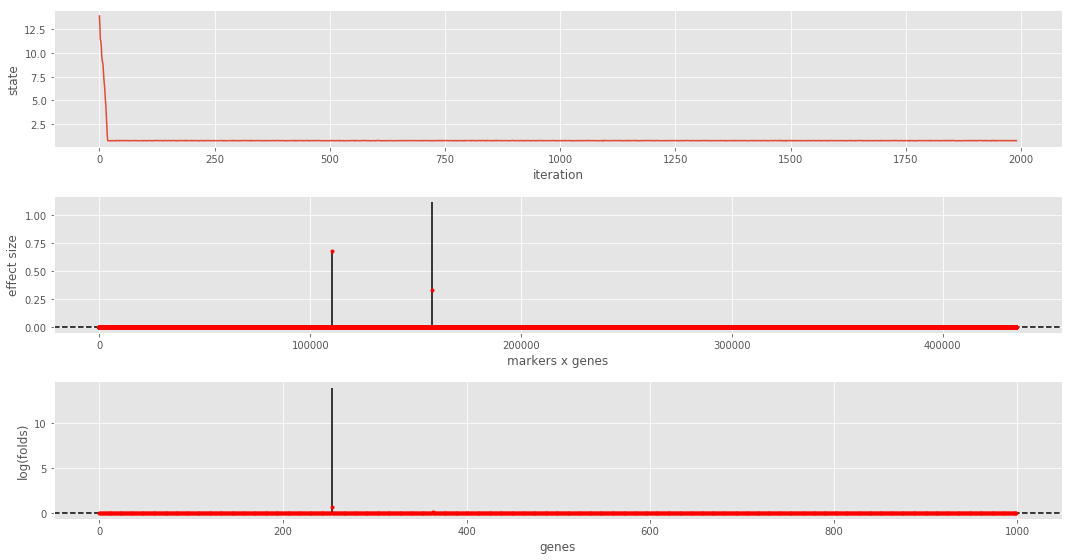

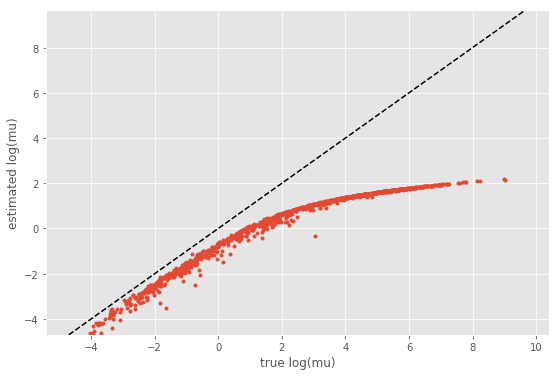

In [54]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(4,1,1); _plt.plot(res['state'][10:]); _plt.xlabel('iteration'); _plt.ylabel('state')
    
    beta_estim = res['beta']# / _nmp.abs(res['beta']).sum()
    beta_true = data['beta']# / _nmp.abs(data['beta']).sum()

    n_genes, n_markers = beta_true.shape

    _plt.subplot(4,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    if 'mu' in res:
        G = data['G']
    #     G = (G - _nmp.mean(G, 0)) / _nmp.std(G, 0)
        folds_true = _nmp.mean(G.dot(beta_true.T), 0) * data['mu']
        folds_estim = _nmp.mean(G.dot(beta_estim.T), 0) * res['mu']
        n_samples, _ = G.shape
        _plt.subplot(4,1,3); 
        _plt.vlines(range(n_genes), 0, folds_true.ravel()); 
        _plt.axhline(linestyle='--', color='k');
        _plt.plot(folds_estim.ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
    
    if 'Y' in res:
        _plt.subplot(4,1,4); 
        _plt.plot(res['Y'].ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
        _plt.axhline(linestyle='--', color='k');

    _plt.tight_layout()
        
    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            var_tru = data['mu'] + data['phi'] * data['mu']**2
            var_est = res['mu'] + res['phi'] * res['mu']**2
            
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(var_tru), _nmp.log(var_est), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

            _plt.subplot(2,2,3)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')
                        
    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
metrics['NRMSE'], metrics['NRMSE_TP'], metrics['MCC'], metrics['FDR'] 

In [ ]:
G = (data['G'] - _nmp.mean(data['G'], 0)) / _nmp.std(data['G'], 0)
folds = G.dot(data['beta'].T)
_plt.figure(); _plt.hist(folds[folds!=0], 100)
_plt.figure(); _plt.boxplot(_nmp.exp(_nmp.abs(folds))[folds!=0])
_nmp.min(_nmp.abs(folds[folds!=0])), _nmp.max(_nmp.abs(folds[folds!=0]))

In [ ]:
_assoc.get_metrics(Z.T, G, res, model='NBinomial', scaleG=True)

In [ ]:
_assoc.get_metrics(Z.T, G, res, model='Binomial', scaleG=True)

In [ ]:
_assoc.get_metrics(Z.T, G, res, model='Poisson', scaleG=True)

In [ ]:
_assoc.get_metrics(Z.T, G, res, model='Normal', scaleG=True)

In [ ]:
_plt.hist(_nmp.log(data['phi']), 100);

In [ ]:
_plt.hist(_nmp.log(_rnd.gamma(shape=1, scale=1, size=4000)),100);

In [ ]:
tmp = _rnd.rand(10,10)
idxs = _rnd.rand(10,10) > 0.5
tmp[idxs] = 0
tmp[~idxs] = 5
tmp

In [ ]:
a = _nmp.c_[_rnd.randn(10,3), _nmp.ones((10,1))];
b = _rnd.randn(10);
sol = _nmp.linalg.lstsq(a,b)
_nmp.allclose(a.dot(sol[0]), b)

In [ ]:
_nmp.min(res['tau'])

In [63]:
_nmp.nonzero(data['beta'])

(array([253, 363]), array([225,  75]))

In [56]:
_nmp.nonzero(_nmp.abs(res['beta'])>1e-6)

(array([253, 363]), array([225,  78]))

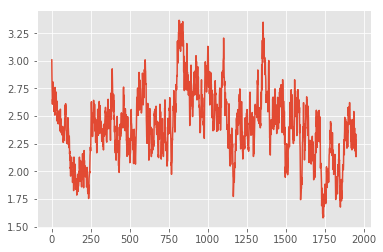

In [22]:
_plt.plot(res['state'][50:])

In [62]:
_nmp.nonzero((_nmp.abs(res['beta'])>1e-6).ravel())

(array([110280, 157983]),)